# EDA and Hypothesis Testing for a Medical Center

- **Author**: Ekaterina Kemenova
- **Date**: 23.12.2025

## 0.1 Project goals and objectives

**Goal:**  
Conduct an exploratory analysis and statistical hypothesis testing on hospital admission data from a federal medical center in order to assess hospitalization duration patterns.

**Context:**  
The management of a federal medical center seeks to understand patient flow and hospitalization timelines in order to assess whether lengths of stay deviate from standard medical benchmarks and differ across patient groups.

**Key objectives:**
- Load and explore the structure of the dataset;
- Clean and prepare the data (handle missing values, duplicates, incorrect data types);
- Conduct an exploratory data analysis to study:
    - the distribution of hospitalization duration;
    - differences in average length of stay across departments;
    - seasonal and temporal dynamics of patient admissions;
- Conduct hypothesis testing to assess deviations from standard hospitalization durations and differences between planned and emergency admissions;
- Summarize findings and provide data-driven recommendations.

## 0.2 Data description

The analysis is based on **`hospital.csv`** — inpatient admissions data from the federal medical center of St. Petersburg State Pediatric Medical University (SPbGPMU), including admission/discharge dates, patient attributes and length-of-stay (LOS) fields.

**Dataset columns:**
- `ДАТА_ПОСТУПЛЕНИЯ` — admission date;
- `ДАТА_ВЫПИСКИ` — discharge date;
- `УНИКАЛЬНЫЙ_ID` — unique patient identifier;
- `НОМЕР_ИБ` — system field;
- `ШИФР` — system field;
- `РЕГИОН` — patient region of residence;
- `ПЛАТЕЛЬЩИК` — payer name;
- `ИСТОЧНИК_ФИНАНСИРОВАНИЯ` — funding source;
- `ОТДЕЛЕНИЕ` — hospital department;
- `ПРОФИЛЬ` — department profile/specialty (e.g., therapy, surgery);
- `КОЙКО_ДНИ` — length of stay in inpatient care (bed-days);
- `ПЛАНОВО_ЭКСТРЕННО` — admission type (planned vs. emergency);
- `КОД_МКБ_ПРИ_ПОСТУПЛЕНИИ` — ICD code at admission;
- `КОД_МКБ_ПРИ_ВЫПИСКЕ` — ICD code at discharge.

## 0.3 Project structure
1. [Data loading and overview](#data-loading-and-overview)
2. [Data preprocessing](#data-preprocessing)
3. [Exploratory data analysis](#exploratory-data-analysis)
4. [Hypothesis testing](#hypothesis-testing)
5. [Final conclusions and recommendations](#final-conclusions-and-recommendations)
---

<a id='data-loading-and-overview'></a>
## 1. Data loading and overview

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st

In [2]:
df = pd.read_csv('hospital.csv')

In [3]:
df.info()

display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125261 entries, 0 to 125260
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ДАТА_ПОСТУПЛЕНИЯ         125261 non-null  object 
 1   ДАТА_ВЫПИСКИ             125261 non-null  object 
 2   УНИКАЛЬНЫЙ_ID            125261 non-null  int64  
 3   НОМЕР_ИБ                 125261 non-null  int64  
 4   ШИФР                     125261 non-null  object 
 5   РЕГИОН                   56391 non-null   object 
 6   ПЛАТЕЛЬЩИК               125261 non-null  object 
 7   ИСТОЧНИК_ФИНАНСИРОВАНИЯ  125261 non-null  object 
 8   ОТДЕЛЕНИЕ                125261 non-null  object 
 9   ПРОФИЛЬ                  125261 non-null  object 
 10  КОЙКО_ДНИ                125261 non-null  float64
 11  ПЛАНОВО_ЭКСТРЕННО        125261 non-null  object 
 12  КОД_МКБ_ПРИ_ПОСТУПЛЕНИИ  125253 non-null  object 
 13  КОД_МКБ_ПРИ_ВЫПИСКЕ      125257 non-null  object 
dtypes: f

,ДАТА_ПОСТУПЛЕНИЯ,ДАТА_ВЫПИСКИ,УНИКАЛЬНЫЙ_ID,НОМЕР_ИБ,ШИФР,РЕГИОН,ПЛАТЕЛЬЩИК,ИСТОЧНИК_ФИНАНСИРОВАНИЯ,ОТДЕЛЕНИЕ,ПРОФИЛЬ,КОЙКО_ДНИ,ПЛАНОВО_ЭКСТРЕННО,КОД_МКБ_ПРИ_ПОСТУПЛЕНИИ,КОД_МКБ_ПРИ_ВЫПИСКЕ
0,01.01.2019,10.01.2019,858042000,1,5.4.1,NaN,"ОАО ""ГСМК"" СПб",ОМС,Микрохирургическое отделение,Сосудистой хирургии,10.0,Экстренная,S61.7,S66.4
1,01.01.2019,01.01.2019,993109000,3,5.13.1,NaN,"СПб филиал ООО ""СМК РЕСО - Мед""",ОМС,Хирургическое отделение №3,Гнойные хирургические,1.0,Экстренная,K37,K63.8
2,01.01.2019,01.01.2019,993111000,4,5.12.1,NaN,"ООО ""Капитал Медицинское Страхование""",ОМС,Хирургическое отделение №3,Гнойные хирургические,1.0,Экстренная,K37,K63.8
3,01.01.2019,07.01.2019,993110000,2,5.4.1,NaN,"ОАО ""ГСМК"" СПб",ОМС,Инфекционное отделение №1,Инфекционные,7.0,Экстренная,B27.9,J03.9
4,01.01.2019,05.01.2019,987185000,5,1.1.1,NaN,Коммерческие,Наличный расчет,ПЦ Акушерское физиологическое отделение,Для беременных и рожениц,5.0,Плановая,O42.9,O82.1


The dataset matches its description; however, column names require normalization to snake_case for consistency.

- The dataset contains **125,261 rows and 14 columns**.
- Missing values are observed in three fields: `РЕГИОН`, `КОД_МКБ_ПРИ_ПОСТУПЛЕНИИ`, `КОД_МКБ_ПРИ_ВЫПИСКЕ`.
- Columns representing dates should be converted to the datetime format.
- The `КОЙКО_ДНИ` variable should be cast to integer.
- Data types for the remaining columns are appropriate and do not require adjustment.

---
<a id='data-preprocessing'></a>
## 2. Data preprocessing

### 2.1. Standardization of column names

In [4]:
new_columns = ['admission_date', 'discharge_date', 'unique_id', 'ib_number', 'code', 'region', 'payer', 'funding_source', 'department', 'profile', 'bed_day', 'admission_type', 'code_admission', 'code_discharge']
df.columns = new_columns

### 2.2. Data type conversion

In [5]:
for column in ['admission_date','discharge_date']:
    df[column] = pd.to_datetime(df[column], format='%d.%m.%Y', errors='raise')

In [6]:
df['bed_day'] = pd.to_numeric(df['bed_day'], downcast='integer')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125261 entries, 0 to 125260
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   admission_date  125261 non-null  datetime64[ns]
 1   discharge_date  125261 non-null  datetime64[ns]
 2   unique_id       125261 non-null  int64         
 3   ib_number       125261 non-null  int64         
 4   code            125261 non-null  object        
 5   region          56391 non-null   object        
 6   payer           125261 non-null  object        
 7   funding_source  125261 non-null  object        
 8   department      125261 non-null  object        
 9   profile         125261 non-null  object        
 10  bed_day         125261 non-null  int16         
 11  admission_type  125261 non-null  object        
 12  code_admission  125253 non-null  object        
 13  code_discharge  125257 non-null  object        
dtypes: datetime64[ns](2), int16(1), int6

### 2.3. Missing values analysis

In [8]:
missing_summary = pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_share': df.isna().mean()
}).sort_values(by='missing_count', ascending=False)

missing_summary

,missing_count,missing_share
region,68870,0.549812
code_admission,8,0.000064
code_discharge,4,0.000032
admission_date,0,0.000000
discharge_date,0,0.000000
unique_id,0,0.000000
ib_number,0,0.000000
code,0,0.000000
payer,0,0.000000
funding_source,0,0.000000


The highest proportion of missing values is observed in the `region` column (approximately 55%). This may reflect either genuinely missing information or a technical issue, since the `payer` column could potentially be used to infer regional affiliation. This assumption should be clarified with the data owner. As the `region` column is not used in the subsequent analysis, missing values are retained.

In the remaining columns (`code_admission` and `code_discharge`), missing values account for a negligible share of the data (less than 0.01%) and are not expected to affect the analysis. These missing values are therefore also retained.

### 2.4. Detection of explicit and implicit duplicates

In [9]:
print (f'Total number of duplicate records: {df.duplicated().sum()}')
print (f'Share of duplicate records: {(df.duplicated().sum()/ df.shape[0])}')

Total number of duplicate records: 4415
Share of duplicate records: 0.035246405505304924


In [10]:
df = df.drop_duplicates()

In [11]:
for column in df.select_dtypes(include='object').columns:
    print(f'\nNumber of unique values in the `{column}` column: {df[column].nunique()}')
    print(f'\nUnique values in the `{column}` column: {df[column].sort_values().unique()}')


Number of unique values in the `code` column: 88

Unique values in the `code` column: ['1.1.1' '1.99.0' '12.3.0' '12.3.0.10' '12.3.0.12' '12.3.0.13' '12.3.0.14'
 '12.3.0.15' '12.3.0.16' '12.3.0.17' '12.3.0.18' '12.3.0.19' '12.3.0.2'
 '12.3.0.20' '12.3.0.21' '12.3.0.22' '12.3.0.24' '12.3.0.25' '12.3.0.26'
 '12.3.0.27' '12.3.0.28' '12.3.0.29' '12.3.0.3' '12.3.0.30' '12.3.0.4'
 '12.3.0.5' '12.3.0.6' '12.3.0.7' '12.3.0.9' '13.1.104' '2.032.6'
 '2.102.1' '2.103.1' '2.104.1' '2.110.1' '2.117.1' '2.12.0' '2.126.1'
 '2.18.0' '2.21.0' '2.21.63' '2.24.0' '2.25.0' '2.28.0' '2.3.1' '2.32.0'
 '2.43.0' '2.5.1' '2.54.0' '2.59.0' '2.6.1' '2.61.0' '2.671.0' '2.673.1'
 '2.674.1' '2.677.0' '2.681.6' '2.683.6' '2.692.0' '2.693.1' '2.698.6'
 '2.701.6' '2.715.6' '2.77.63' '2.78.6' '2.8.0' '5.1.1' '5.116.0' '5.12.1'
 '5.13.1' '5.186.1' '5.2.1' '5.25.1' '5.4.1' '5.47.1' '5.47042.1'
 '5.47043.1' '5.47045.1' '5.5.1' '5.666.0' '5.666.1' '5.69.1' '5.7.1'
 '5.9.1' '5.99.0' '6.1.0' '8.1.0' '9.2.0']

Number of uniq

We standardize region names to prevent implicit duplicates caused by inconsistent formatting:

In [12]:
df['region'] = df['region'].str.lower().str.strip()

replacements = {
    'область': 'обл',
    'обл.': 'обл',
    'респ-ка': 'респ',
    'респ.': 'респ',
    'р-ка': 'респ',
    'республ.': 'респ',
    'республика': 'респ',
    'г. ': '',
    'г ': '',
    'лен ': 'ленинградская ',
    'лениградская': 'ленинградская ',
    'ленинградская  обл': 'ленинградская обл',
    'респ абхазия': 'абхазия',
    'респ армения': 'армения',
    'респ киргизия': 'киргизия',
    'кыргызская респ': 'киргизия',
    'респ туркменистан': 'туркменистан',
    'луганская народная респ': 'лнр',
    'луганская обл': 'лнр',
    'донецкая обл': 'днр',
    'респ донецкая народная': 'днр',
    'респ лнр': 'лнр',
    'реcпублика украина': 'украина'
}

for old, new in replacements.items():
    df['region'] = df['region'].str.replace(old, new, regex=False)

In [13]:
df['region'].nunique()

122

Explicit duplicates were identified in 3.5% of the records and subsequently removed. In addition, values in the `region` column were standardized to eliminate potential implicit duplicates.

---
<a id='exploratory-data-analysis'></a>
## 3. Exploratory data analysis

We analyze the distribution of hospitalization duration:

In [14]:
df['bed_day'].describe()

count    120846.000000
mean          8.730988
std           8.776465
min           1.000000
25%           3.000000
50%           7.000000
75%          12.000000
max         266.000000
Name: bed_day, dtype: float64

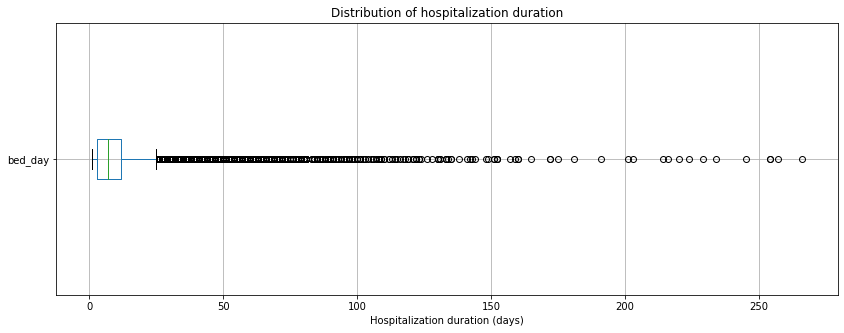

In [15]:
plt.figure(figsize=(14, 5))

df.boxplot(column=['bed_day'],vert=False)

plt.title('Distribution of hospitalization duration')
plt.xlabel('Hospitalization duration (days)')
plt.show()

The median length of hospitalization is **7 days**, while the mean is 9 days. Most hospital stays fall between **3** (Q1) and **12 days** (Q3).

The distribution is right-skewed and contains a large number of upper-end outliers, indicating that some patients experience unusually long hospital stays.

Next, we examine the average hospitalization duration by department:

In [16]:
top_10 = df.groupby('department')['bed_day'].mean().sort_values(ascending=False).head(10)
top_10

department
Отделение анестезиологии-реанимации                                                  45.179487
ПЦ ОАРИТН №1 (новорожденных)                                                         28.723214
ПЦ Отделение Анестезиологии-реанимации для детей с кардиохирургической патологией    26.438095
ПЦ Отделение патологии новорожденных и детей грудного возраста                       22.200586
ПЦ Отделение вспомогательных репродуктивных технологий ДС                            21.297802
Дневной стационар Кожно-венерологического отделения                                  14.027322
Дневной стационар Гастроэнтерологического отделения                                  13.339286
Микрохирургическое отделение                                                         13.293007
Педиатрическое отделение №1                                                          12.824642
Дневной стационар эндокринологического отд.                                          12.766667
Name: bed_day, dtype: float64

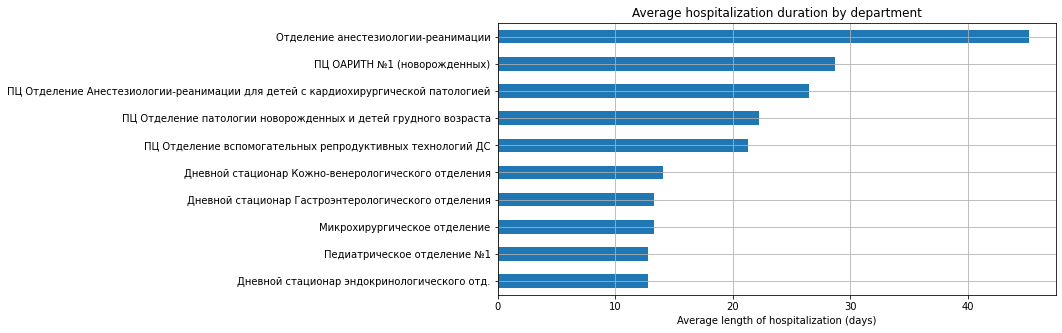

In [17]:
plt.figure (figsize = (10,5))
top_10.sort_values(ascending=True).plot(
                kind='barh',
                title='Average hospitalization duration by department',
                rot=0,
                legend=False)
plt.xlabel('Average length of hospitalization (days)')
plt.ylabel('')
plt.grid()
plt.show()

The top 3 departments with the longest hospitalization durations are **intensive care departments**. The leading department — anesthesiology and intensive care — stands out significantly from the others, with an average length of stay of approximately **45 days**.

**Neonatal and perinatal departments** follow (including pathology of newborns and neonatal intensive care), with consistently long stays of **22–29 days**, reflecting the clinical complexity and need for prolonged monitoring. **Reproductive medicine and neonatal pathology** departments show similarly elevated durations (around **21–22 days**).

Day hospital departments and general pediatric or surgical departments exhibit substantially shorter stays, typically 12–14 days, consistent with planned admissions and standard inpatient care.

Next, we analyze the monthly dynamics of patient admissions:

In [18]:
df['month'] = df['admission_date'].dt.month
df['year'] = df['admission_date'].dt.year

In [19]:
admissions_count = pd.pivot_table(df, index=['year','month'], values='unique_id', aggfunc='count').reset_index()
admissions_count

,year,month,unique_id
0,2019,1,1775
1,2019,2,1927
2,2019,3,2080
3,2019,4,2205
4,2019,5,2020
5,2019,6,1957
6,2019,7,1102
7,2019,8,1183
8,2019,9,2020
9,2019,10,2598


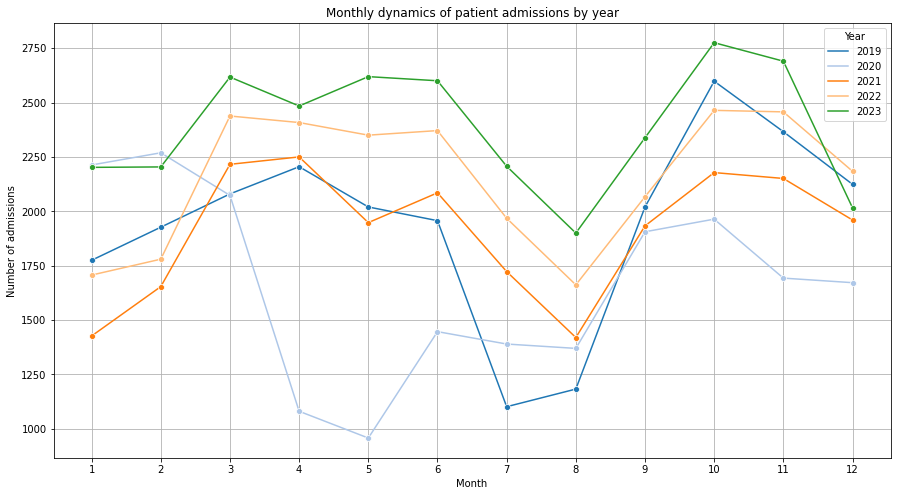

In [20]:
plt.figure (figsize = (15,8))

sns.lineplot(data=admissions_count, x='month', y='unique_id', hue='year', palette='tab20', marker = 'o')

plt.title('Monthly dynamics of patient admissions by year')
plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('Number of admissions')
plt.grid()
plt.legend(title='Year')
plt.show()

A clear **seasonal pattern** in patient admissions is observed. Admissions **peak in autumn** (October–November) and **spring** (March–May), while a **decline** is evident during the **summer months** (July–August). The 2020 trajectory deviates sharply from other years, showing a pronounced drop in April–May, likely reflecting an external shock (the COVID-19 pandemic) that reduced planned hospitalizations.

---
<a id='hypothesis-testing'></a>
## 4. Hypothesis testing

We examine whether the observed average hospitalization duration differs from the standard seven-day benchmark:

- **H0:** The mean hospitalization duration is equal to 7 days.  
- **H1:** The mean hospitalization duration is not equal to 7 days.

In [21]:
mean = 7
admission = df['bed_day']
alpha = 0.05

results = st.ttest_1samp(admission, mean)

print(f'Average hospitalization duration: {admission.mean()} days')
print(f'p-value: {results.pvalue:.10e}')

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Average hospitalization duration: 8.73098819985767 days
p-value: 0.0000000000e+00
Reject the null hypothesis


The one-sample t-test **rejects the null hypothesis**, indicating that the mean hospitalization duration (8.73 days) differs statistically from the seven-day benchmark. The observed mean length of stay is statistically higher than the reference value.

Next, we test whether the average length of hospitalization exceeds 10 days:

**H0:** The mean hospitalization duration is equal to 10 days.  
**H1:** The mean hospitalization duration is greater than 10 days.

In [22]:
mean = 10
admission = df['bed_day']
alpha = 0.05

results = st.ttest_1samp(admission, mean, alternative = 'greater')
p_value = results.pvalue

print(f'Average hospitalization duration: {admission.mean()} days')
print(f'p-value: {results.pvalue:.10e}')

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Average hospitalization duration: 8.73098819985767 days
p-value: 1.0000000000e+00
Fail to reject the null hypothesis


The one-sample t-test **fails to reject the null hypothesis**, indicating that the mean hospitalization duration (8.73 days) does not exceed 10 days. There is no statistical evidence that the mean length of stay is greater than 10 days.

Finally, we test whether the average length of hospitalization differs between planned and emergency admissions:

- **H0:** The mean hospitalization duration for planned patients is equal to that for emergency patients.  
- **H1:** The mean hospitalization duration for planned patients differs from that for emergency patients.

In [23]:
df[df['admission_type'] == 'Плановая']['bed_day'].describe()

count    86416.000000
mean         9.719045
std          8.348448
min          1.000000
25%          4.000000
50%          8.000000
75%         13.000000
max        257.000000
Name: bed_day, dtype: float64

In [24]:
df[df['admission_type'] == 'Экстренная']['bed_day'].describe()

count    34430.000000
mean         6.251060
std          9.318009
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max        266.000000
Name: bed_day, dtype: float64

The group variances are not equal (std differs), so we apply the Welch two-sample t-test:

In [25]:
sample_plan = df[df['admission_type'] == 'Плановая']['bed_day']
sample_urgent = df[df['admission_type'] == 'Экстренная']['bed_day']
alpha = 0.05

results = st.ttest_ind(sample_plan, sample_urgent, equal_var=False)
p_value = results.pvalue

print(f'Plan:  n={len(sample_plan)}, mean={sample_plan.mean():.2f}, median={sample_plan.median():.2f}')
print(f'Urgent: n={len(sample_urgent)}, mean={sample_urgent.mean():.2f}, median={sample_urgent.median():.2f}')
print(f'p-value: {results.pvalue:.10e}')

if p_value < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

Plan:  n=86416, mean=9.72, median=8.00
Urgent: n=34430, mean=6.25, median=3.00
p-value: 0.0000000000e+00
Reject the null hypothesis


Given the presence of outliers, we additionally apply the Mann–Whitney U test as a non-parametric robustness check:

In [26]:
sample_plan = df[df['admission_type'] == 'Плановая']['bed_day']
sample_urgent = df[df['admission_type'] == 'Экстренная']['bed_day']
alpha = 0.05

results = st.mannwhitneyu(
    sample_plan,
    sample_urgent)

print(f'p-value: {results.pvalue:.10e}')

if results.pvalue < alpha:
    print('Reject the null hypothesis')
else:
    print('Fail to reject the null hypothesis')

p-value: 0.0000000000e+00
Reject the null hypothesis


Both the Welch t-test and the Mann–Whitney U test **reject the null hypothesis**, indicating a statistically significant difference in the mean hospitalization duration between planned and emergency admissions. Planned patients stay in the hospital longer on average (mean ≈ 9.7 days, median = 8 days) than emergency patients (mean ≈ 6.3 days, median = 3 days).

---
<a id='final-conclusions-and-recommendations'></a>
## 5. Final conclusions and recommendations

### 5.1 Key insights

- **Hospitalization duration**: The distribution is right-skewed with numerous upper-end outliers; median = 7 days, mean = 8.73 days;
- **Department differences**: The longest average length of stay is observed in intensive care/anesthesiology and neonatal/perinatal departments, while day hospitals show shorter, more typical stays;
- **Seasonality**: Patient admissions exhibit clear seasonality, peaking in spring (March–May) and autumn (October–November) and declining during the summer months (July–August);
- **Hypothesis testing**:
    - The mean hospitalization duration differs significantly from the 7-day benchmark (mean = 8.73 days).
	- The mean hospitalization duration does not exceed 10 days (not statistically significant).
	- The mean hospitalization duration differs significantly between planned and emergency admissions.

### 5.2 Recommendations
- **Plan capacity beyond the 7-day benchmark:** The mean hospitalization duration exceeds 7 days (mean = 8.73 days), and the distribution is right-skewed with a long tail. Capacity planning should therefore not rely on the 7-day benchmark alone and should include buffer capacity to accommodate long-stay patients.
- **Differentiate operational planning by admission type:** Hospitalization duration differs significantly between planned and emergency admissions (planned stays are longer on average). Use separate capacity assumptions and scheduling rules for planned vs. emergency flows (e.g., reserved emergency buffer beds).
- **Prioritize high–length-of-stay departments:** Intensive care/anesthesiology and neonatal/perinatal departments account for the longest stays and should be the primary focus of targeted capacity planning and patient-flow management.
- **Align staffing and bed allocation with seasonality:** Use observed seasonal patterns for tactical resource planning: increase staffing/bed availability ahead of peak periods and schedule elective activity, maintenance, and training during seasonal troughs.